# Note:

**В этом ноутбуке, а также в аналогичном для Prophet рассматривается влияние начало и конца промежутка для обучения на качество модели.**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pyramid
import math
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from sklearn import metrics
import pandas as pd
from pyramid.arima import auto_arima

np.random.seed(123)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [2]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [3]:
Time = np.arange(0,300)

# Plotting features

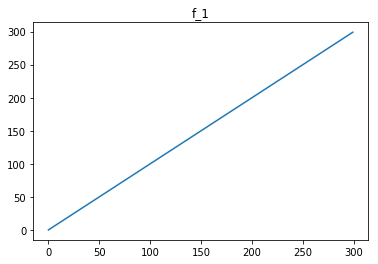

In [4]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

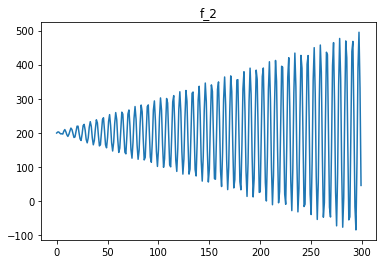

In [5]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

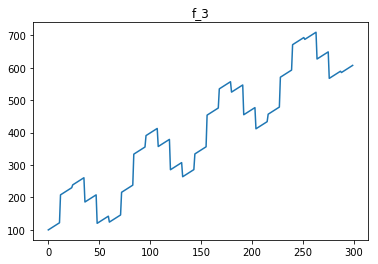

In [6]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

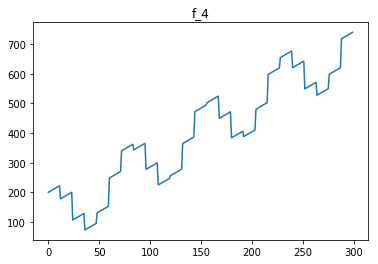

In [7]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

 # Plotting time-series

In [8]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis =1)
print (Exog.shape)

(300, 4)


In [9]:
y_1 = generate_ts_1(Exog)
y_2 = generate_ts_2(Exog)

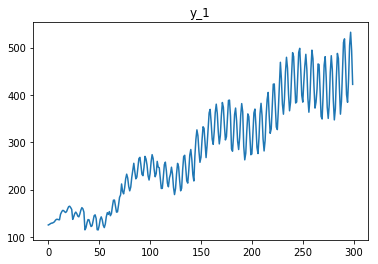

In [10]:
y_1 = generate_ts_1(Exog)

plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

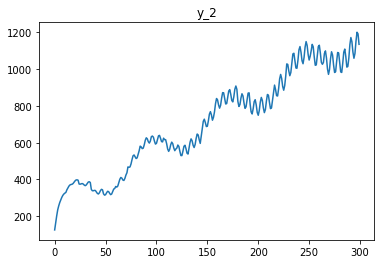

In [11]:
y_2 = generate_ts_2(Exog)

plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

# Pyramid_functions

In [12]:
def pyramid_stepwise(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, period = 12, n_periods = 100,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore', information_criterion = 'aic',trend = 'c',
                          suppress_warnings=True, n_jobs = 1,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data, exogenous=Exog_train, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore',information_criterion = 'oob',trend = 'c',
                          suppress_warnings=True, n_jobs = 1,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

In [13]:
def pyramid_random_search(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, 
                          period = 12, n_periods = 100, n_fits = 200, n_jobs = 1, random_state = 42,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data,start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                    start_P=0, start_Q = 0, n_jobs=n_jobs, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                    error_action='ignore', information_criterion = 'aic', trend = 'c',
                    suppress_warnings=True,
                    stepwise=False, random=True, random_state=random_state, n_fits = n_fits)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data,exogenous=Exog_train,start_p=0, start_q=0, max_p=5, max_q=5,m=period,
                    start_P=0, start_Q = 0, n_jobs=n_jobs, max_d = 2, max_D = 2, max_P=5, max_Q=5, trace=False,
                    error_action='ignore',  
                    suppress_warnings=True, information_criterion = 'oob', trend = 'c',
                    stepwise=False, random=True, random_state=42,
                    n_fits=1000)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

# Train-test-split

In [14]:
start_point = 80
middle_point = 125
end_point = 175


y_train_1 = y_1[start_point: middle_point]
y_test_1 = y_1[middle_point: end_point]

y_train_2 = y_2[start_point: middle_point]
y_test_2 = y_2[middle_point: end_point]

exog_train = Exog[start_point: middle_point]
exog_test = Exog[middle_point: end_point]

print("samples in train: ", y_train_1.shape, "samples in test: ", y_test_1.shape)

samples in train:  (45, 1) samples in test:  (50, 1)


## Data frame 1

# without exogenous:

# StepWise

In [15]:
model_1_st, in_sample_preds_1_st,next_validate_1_st = pyramid_stepwise(y_train_1, Exog_train=exog_train,
                                    Exog_test=exog_test, exog_flag=False, n_periods = len(y_test_1))
print (model_1_st.summary())

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(2, 0, 1)x(2, 0, 0, 12)   Log Likelihood                -152.632
Date:                            Thu, 12 Jul 2018   AIC                            319.265
Time:                                    18:31:01   BIC                            331.912
Sample:                                         0   HQIC                           323.979
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    106.4411     26.831      3.967      0.000      53.853     159.029
ar.L1          1.3952      0.126   

In [16]:
in_sample_preds_1_st.shape, next_validate_1_st.shape

((45,), (50,))

In [17]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_st, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_st, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.32 
 MAE:  64.858


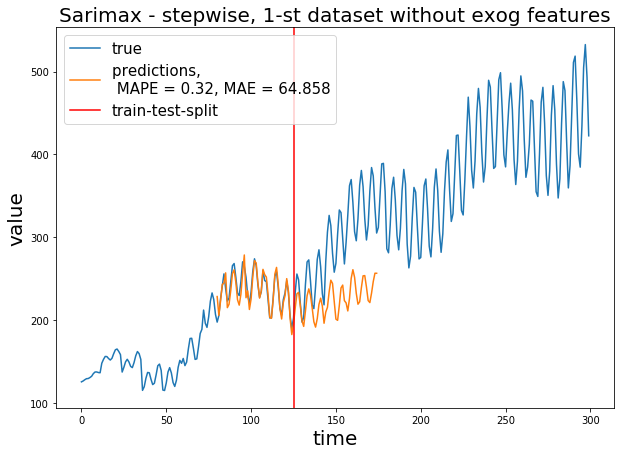

In [18]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_st, next_validate_1_st]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Random Search

In [19]:
model_1_rs, in_sample_preds_1_rs,next_validate_1_rs = pyramid_random_search(y_train_1, Exog_train=exog_train,Exog_test=exog_test,
                        exog_flag=False, n_fits = 5000, n_periods = len(y_test_1))
print (model_1_rs.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(3, 0, 3)x(2, 0, 0, 12)   Log Likelihood                -127.672
Date:                            Thu, 12 Jul 2018   AIC                            275.345
Time:                                    18:31:54   BIC                            293.411
Sample:                                         0   HQIC                           282.080
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.8807     21.572      0.968      0.333     -21.399      63.160
ar.L1          1.9599      0.123   

In [20]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_rs, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_rs, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.315 
 MAE:  62.75


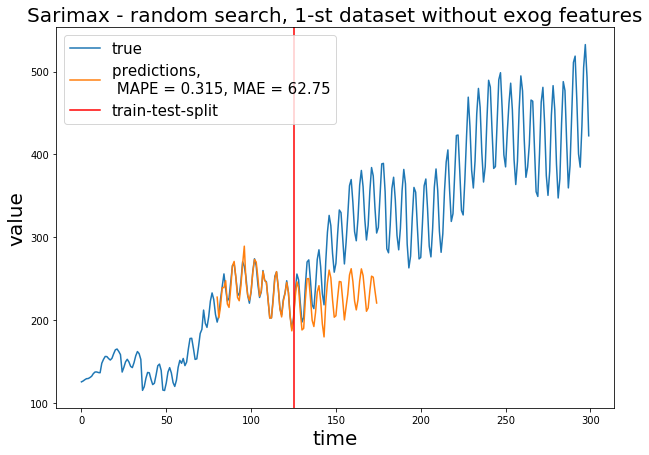

In [21]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_rs, next_validate_1_rs]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# with exogenous:

# StepWise

In [22]:
model_1_st_we, in_sample_preds_1_st_we, next_validate_1_st_we = pyramid_stepwise(y_train_1, 
                    Exog_train=exog_train, Exog_test=exog_test, exog_flag=True, n_periods = len(y_test_1))
print (model_1_st_we.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:                        SARIMAX   Log Likelihood                1335.719
Date:                Thu, 12 Jul 2018   AIC                          -2659.438
Time:                        18:31:55   BIC                          -2648.598
Sample:                             0   HQIC                         -2655.397
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.105e-13   1.14e-14      9.718      0.000    8.82e-14    1.33e-13
x1             0.2500   2.53e-16   9.87e+14      0.000       0.250       0.250
x2             0.2500   5.03e-17   4.97e+15      0.0

In [23]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_st_we, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_st_we, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.211 
 MAE:  0.0


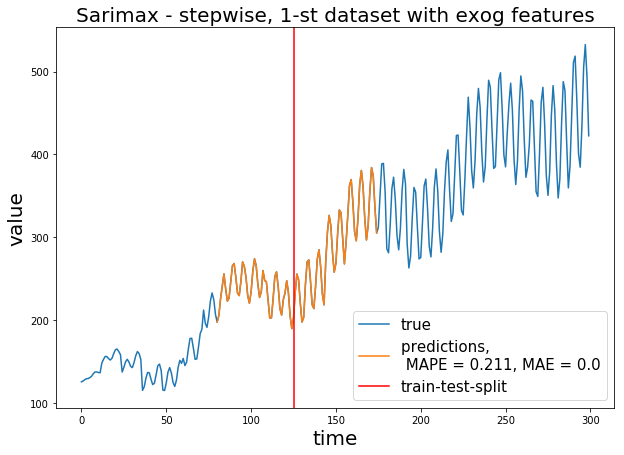

In [24]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_st_we, next_validate_1_st_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 1-st dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# RandomSearch

In [25]:
model_1_rs_we, in_sample_preds_1_rs_we,next_validate_1_rs_we = pyramid_random_search(y_train_1,
            Exog_train=exog_train, Exog_test=exog_test, exog_flag=True, n_fits =5000, n_periods = len(y_test_1))
 
print (model_1_rs_we.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(1, 0, 5)x(2, 0, 0, 12)   Log Likelihood                 916.094
Date:                            Thu, 12 Jul 2018   AIC                          -1804.188
Time:                                    18:33:15   BIC                          -1778.894
Sample:                                         0   HQIC                         -1794.759
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.989e-14   2.82e-17   2126.246      0.000    5.98e-14    5.99e-14
x1             0.2500   6.53e-17   

In [26]:
mape = np.round(mean_absolute_percentage_error(next_validate_1_rs_we, y_test_1), 3)

mae = np.round(mean_absolute_error(next_validate_1_rs_we, y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.211 
 MAE:  0.0


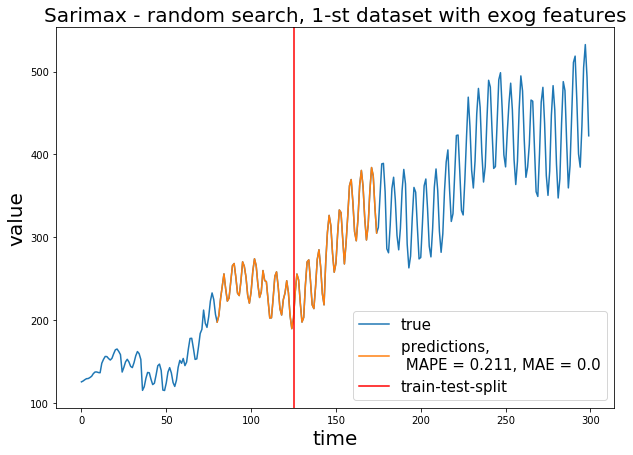

In [27]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_1_rs_we, next_validate_1_rs_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 1-st dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

## Data frame 2

# without exogenous:

# Stepwise

In [28]:
model_2_st, in_sample_preds_2_st,next_validate_2_st = pyramid_stepwise(y_train_2, Exog_train=exog_train,
                                Exog_test=exog_test, exog_flag=False, n_periods = len(y_test_1))

print (model_2_st.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(4, 0, 1)x(2, 0, 0, 12)   Log Likelihood                -148.089
Date:                            Thu, 12 Jul 2018   AIC                            314.179
Time:                                    18:33:26   BIC                            330.439
Sample:                                         0   HQIC                           320.240
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     66.5552     32.380      2.055      0.040       3.091     130.019
ar.L1          0.9855      0.344   

In [29]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_st, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_st, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.274 
 MAE:  154.478


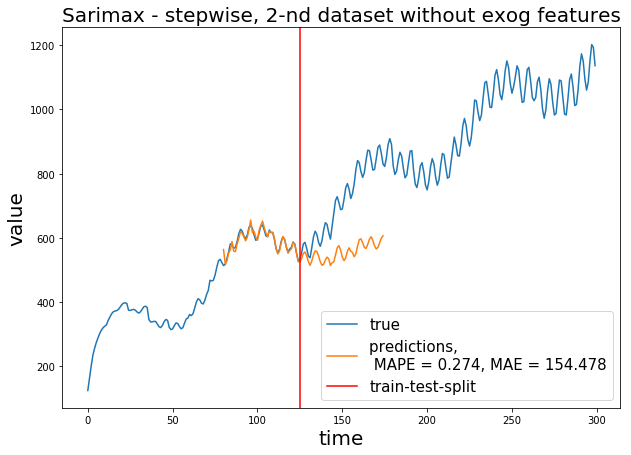

In [30]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_st, next_validate_2_st]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Random Search

In [31]:
model_2_rs, in_sample_preds_2_rs,next_validate_2_rs = pyramid_random_search(y_train_2, Exog_train=exog_train,
                    Exog_test=exog_test, exog_flag=False, n_fits = 5000, n_periods = len(y_test_2))


print (model_2_rs.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(3, 0, 3)x(2, 0, 1, 12)   Log Likelihood                -130.611
Date:                            Thu, 12 Jul 2018   AIC                            283.222
Time:                                    18:34:24   BIC                            303.095
Sample:                                         0   HQIC                           290.630
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.1174     20.829      0.198      0.843     -36.707      44.942
ar.L1          2.0478      0.057   

In [32]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_rs, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_rs, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.185 
 MAE:  113.435


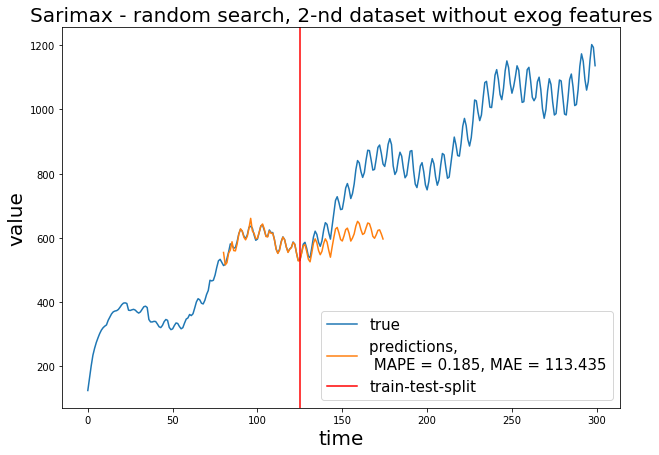

In [33]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_rs, next_validate_2_rs]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# with exogenous:

In [34]:
model_2_st_we, in_sample_preds_2_st_we,next_validate_2_st_we = pyramid_stepwise(y_train_2,
                Exog_train=exog_train, Exog_test=exog_test, exog_flag=True, n_periods = len(y_test_2))


print (model_2_st_we.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   45
Model:                        SARIMAX   Log Likelihood                -171.220
Date:                Thu, 12 Jul 2018   AIC                            354.440
Time:                        18:34:26   BIC                            365.280
Sample:                             0   HQIC                           358.481
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    195.6684     67.403      2.903      0.004      63.561     327.776
x1             0.5188      0.324      1.602      0.109      -0.116       1.154
x2             0.2439      0.029      8.391      0.0

In [35]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_st_we, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_st_we, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.054 
 MAE:  38.263


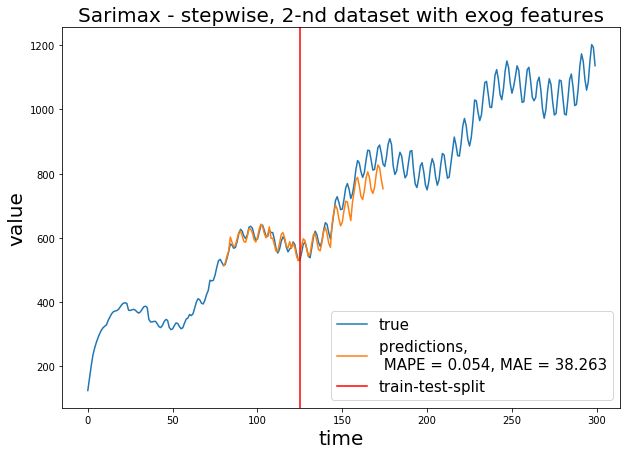

In [36]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_st_we, next_validate_2_st_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - stepwise, 2-nd dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

In [37]:
model_2_rs_we, in_sample_preds_2_rs_we,next_validate_2_rs_we = pyramid_random_search(y_train_2,
    Exog_train=exog_train,Exog_test=exog_test, exog_flag=True,n_fits =5000, n_periods = len(y_test_2))


print (model_2_rs_we.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 12)   Log Likelihood                -161.469
Date:                            Thu, 12 Jul 2018   AIC                            340.939
Time:                                    18:34:46   BIC                            357.199
Sample:                                         0   HQIC                           347.000
                                             - 45                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5485     37.793      0.015      0.988     -73.524      74.621
x1             1.5666      0.427   

In [38]:
mape = np.round(mean_absolute_percentage_error(next_validate_2_rs_we, y_test_2), 3)

mae = np.round(mean_absolute_error(next_validate_2_rs_we, y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.057 
 MAE:  43.463


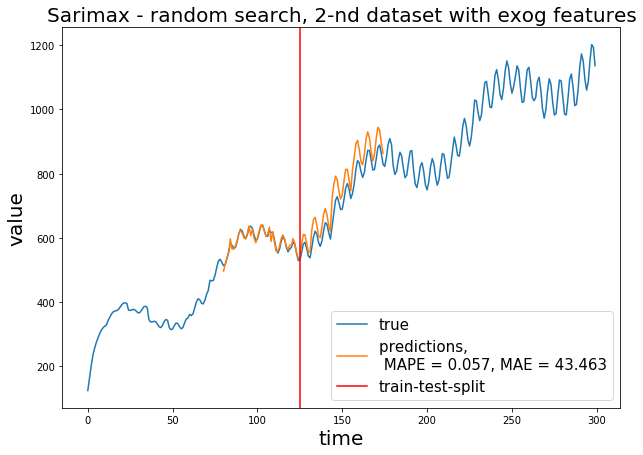

In [39]:
plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point:end_point], np.concatenate([in_sample_preds_2_rs_we, next_validate_2_rs_we]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title("Sarimax - random search, 2-nd dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

**Результат хороший, но уступает Prophet. Как видно, при уменьшении обучающей выборки, качество прогноза ухудшилось.**